
# Air Quality and COVID-19 Infection Rates
For this project, our goal is to investigate a **possible** relationship between Air Quality and COVID-19 Infection Rates. To that end, we merged an Air Quality dataset with a COVID-19 dataset, performed preprocessing before and after the merge, trained a regression model on the merged dataset, and performed predictions to test the accuracy of our model.

As an exploration, we attempted to exhaust all relevant regression models whose parameters have been appropriately tuned (if possible), from Support Vector Machines to Linear Regressors, which is what we settled with. All relevant preprocessing steps, from data cleaning, feature renaming and imputation, to pruning, feature selection and standardization, have also been taken.

In order to simplify our problem, we have decided to only focus on California Air Quality and COVID-19 datasets. The data were sourced directly from the government agencies of the state of California. This choice is motivated by the difficulty of procuring day-to-day Air Quality and COVID-19 data from the Philippines. We require day-to-day data for a more granular data source.

Because our preprocessed dataset only holds continuous quantitative values, regression is the most appropriate modeling approach.

**Important:** Because this is an exploratory project, we are not absolutely certain that there exists a significant relationship between Air Quality and COVID-19 datasets. Furthermore, our results, significant or not, can only lend support to hypotheses surrounding Air Quality and COVID-19.

## Importing the Datasets
Let us look at the samples, features, and other details regarding the dataset so that we know what we're dealing with. But first, we need to import the datasets into manipulable dataframes.

In [ ]:
# Set Jupyter Notebook to clear all workspace variables before the next complete run
%reset -f
# Set Jupyter Notebook to print out all interactions. This makes all "display" command from
%config InteractiveShell.ast_node_interactivity = 'all'

# Fetching all Air Quality datasets into their dataframes
# Perform immediate concatenation per year
import os
import pandas as pd

# Initialize datasets using co (do not add extra datasets to dir)
dir = 'CAdata/'
colidx = [0,2,4,17]                             # column indexes to use
innerkeys = ['Date', 'Site ID', 'COUNTY']       # Merge on Date, Site ID, and COUNTY
dataA2020 = pd.read_csv(dir + 'cf-2020-co.csv', parse_dates=True, usecols=colidx)
dataA2021 = pd.read_csv(dir + 'cf-2021-co.csv', parse_dates=True, usecols=colidx)
dataA2022 = pd.read_csv(dir + 'cf-2022-co.csv', parse_dates=True, usecols=colidx)

with os.scandir(dir) as datasets:
    for dataset in datasets:
        if dataset.is_file() and 'co' not in dataset.name:
            temp = pd.read_csv(dataset, parse_dates=True, usecols=colidx)
            if '2020' in dataset.name:
                dataA2020 = pd.merge(dataA2020, temp, how='outer', on=innerkeys)
            elif '2021' in dataset.name:
                dataA2021 = pd.merge(dataA2021, temp, how='outer', on=innerkeys)
            elif '2022' in dataset.name:
                dataA2022 = pd.merge(dataA2022, temp, how='outer', on=innerkeys)

# Parse Dates to date
dataA2020['Date'] = pd.to_datetime(dataA2020['Date'])
dataA2021['Date'] = pd.to_datetime(dataA2021['Date'])
dataA2022['Date'] = pd.to_datetime(dataA2022['Date'])
dataA2020.head()
dataA2021.head()
dataA2022.head()

# DataA : Temporary Datasets
The initial datasets drops the 'Site ID' Column and then groups them by year. These datasets contain the air contents as well as the date in which they are recorded. They are grouped depending on their year since the initial datasets are limited to their own year.

In [ ]:
# Group data by Date and Site ID, then by Date again to remove the Site ID feature
# Result would be mean measurements per day
dataA2020 = dataA2020.drop(columns=['Site ID'], axis=1).groupby(by=['Date']).mean()
dataA2021 = dataA2021.drop(columns=['Site ID'], axis=1).groupby(by=['Date']).mean()
dataA2022 = dataA2022.drop(columns=['Site ID'], axis=1).groupby(by=['Date']).mean()
dataA2020.head()
dataA2021.head()
dataA2022.head()

## Merging of Temporary Datasets into one dataset (Dataset A)
This is where Air Particles concentration from each year are merged into one whole dataset (2020-2023) which will be used later on.

In [ ]:
dataA = pd.concat([dataA2020, dataA2021, dataA2022])    # Combine the three datasets
print("Combined dataset (Date set as index)")
dataA

## Column Renaming:
This is where we shorten the name of each air contaminants to a corresponding concise name along with their corresponsing units.

In [ ]:
new_names = ['CO conc (ppm)', 'NO2 conc (ppb)', 'O3 conc (ppm)',
             'Pb conc (ug/m3 SC)', 'PM10 conc (ug/m3 SC)',
             'PM2.5 conc (ug/m3 LC)', 'SO2 conc (ppb)']

# Rename columns
for i in range(len(new_names)):
    dataA.rename(columns={dataA.columns[i]: new_names[i]}, inplace=True)

print("Columns renamed:")
dataA.head()

### Checking null values in the dataset
This is where we checked the null values on the dataset and decide what actions are needed to be done. In this case, imputing is the best course of action that we decided to do.

In [ ]:
import seaborn as sns

# Deciding whether to drop or impute null values, so we check how many null values there are.
# Dataset A impute
print("A: Number of entries with null values:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

### Imputation
This is where we begin using an imputer to fill in the null values that the original dataset contains.

In [ ]:
# These imports are important, imputer relies on them.

from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer   # Important!
from sklearn.impute import IterativeImputer     # default imputer is BayesianRidge

from sklearn.linear_model import BayesianRidge

# Other estimators (estimator = func()) to try
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Initialize imputer
imp = IterativeImputer(max_iter=100, random_state=1, verbose=True, estimator=BayesianRidge())
dataA[:] = imp.fit_transform(dataA)

print("After imputation:")
dataA.head()
print("A: Number of entries with null values after impute:", dataA.isna().any(axis=1).sum())
print("A: Number of entries:", dataA.shape[0])

## Dataset B
This is the second dataset that we are going to use alongside dataset A. This contains the COVID-19 data, specifically the date when it was recorded, the state that it came from, the total covid cases, confirmed covid cases, probable covid cases and the sum of the new cases that arose that day.

In this dataset, we limit our data to the state of California (CA). Then, we used the date when the data was gathered as the index of the dataset. After that, we filtered dataset A with the date available in dataset B.

Finally, we checked the null values of dataset B to determine whether we need to impute or not. In this case, we don't need to impute since it has clean data.

In [ ]:
colidx = [0,1,2,3,4,5,6]     # column indexes to use (based on preemptively looking at dataB)
dataB = pd.read_csv('datasets/us_covid_cases_and_deaths_by_state.csv', parse_dates=True, usecols=colidx)
sum_new_cases = dataB['new_case'] + dataB['pnew_case']
dataB.drop(['new_case', 'pnew_case'], axis=1, inplace=True)
dataB['sum_new_cases'] = sum_new_cases
dataB.head()

dataB.columns = ['Date', 'State', 'Total Cases', 'Confirmed Cases', 'Probable Cases', 'Sum New Cases']

# Filter dataset B
dataB = dataB[dataB['State'] == 'CA']
dataB.head()

# Use Date as index, also drop the State
print("Dateset B finalized")
dataB['Date'] = pd.to_datetime(dataB['Date'])
dataB.set_index('Date', inplace=True)
dataB.sort_index(inplace=True)
dataB.drop('State', axis=1, inplace=True)
dataB.info()
dataB.head()

# Filter dataA with temporal restriction given by dataB
dataA = dataA[(dataA.index >= dataB.index.min()) &
              (dataA.index <= dataB.index.max())]

print("Filtered Dataset A")
dataA.head()

# With the printouts below, we find that there's no need to impute.
print("B: Number of entries with null values:", dataB.isna().any(axis=1).sum())
print("B: Number of entries:", dataB.shape[0])

## Merging of Main Datasets (data = dataA + dataB)
This is where we merged the air quality dataset and the COVID-19 dataset into one dataframe called 'data'.

In [ ]:
# Merging the two datasets (dataA & dataB)
data = dataA.merge(dataB, left_index=True, right_index=True)
data

## Pruning
This is where we pruned each column of the dataset in order to reach maximum efficiency. We also removed some columns that we determined to be skewing the prediction in the wrong way.

This also shows a scatter plot of each feature matrix column (except for Total Cases) with the target matrix (Sum New Cases).

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# GENERATE SCATTERPLOTS FOR EDUCATED GUESSES OF WHAT COLUMNS TO USE
# DYNAMIC PRUNING
# IDEA: We focus on ambient level of pollutants and ignore sudden spikes in COVID-19 case data (i.e. data dumps).
# We also remove Dates where there are no new infections as their volume skews the data alot.
data = data[(data['Sum New Cases'] <= 73000) & (data['Sum New Cases'] > 1)]
data = data[(data['Total Cases'] > 0)]
data = data[(data['Confirmed Cases'] > 0)]
data = data[data['CO conc (ppm)'] <= 1.5]
# data = data[data['NO2 conc (ppb)'] > 1]
data = data[data['O3 conc (ppm)'] > 0.035]
data = data[data['Pb conc (ug/m3 SC)'] < 0.5]
data = data[data['PM10 conc (ug/m3 SC)'] < 100]
data = data[data['PM2.5 conc (ug/m3 LC)'] < 15]
data = data[data['SO2 conc (ppb)'] < 2.0]

# DROP COLUMNS HERE
data.drop(columns=['PM10 conc (ug/m3 SC)'], axis=1, inplace=True)
# data = data[['PM10 conc (ug/m3 SC)', 'Sum New Cases']]

for label in data.columns:
    if label in ['Sum New Cases', 'Total Cases', 'Confirmed Cases']: continue
    sns.set_style('dark')

    sns.relplot(x=label, y='Sum New Cases', data=data, height=3.8, aspect=1.8, kind='scatter')

print("Number of entries remaining after pruning:", data.shape[0])

### Regression Plot
This contains regression plots of each column in the feature matrix (except for Total Cases) with the target matrix (Sum New Cases).

In [ ]:
fig, axs = plt.subplots(nrows=len(data.columns), ncols=1, figsize=(16,64))

i = 0
for label in data.columns:
    if label in ["Sum New Cases", "Total Cases"]: continue
    sns.regplot(x=label, y='Sum New Cases', data=data, ci=95, scatter_kws={'s':100, 'facecolor':'red'}, ax=axs[i])
    i += 1

## Linear Regression
Here we initially started with the initialization of the StandardScaler. Then, we grouped the component of the dataset depending on their classification, whether they are the Target Vector (Sum New Cases) or the Feature Matrix (remaining columns in the dataframe).

Now that we have our x and y, we utilized train_test_split to separate the train data from the test data. Then finally, we started our Linear Regression with the variable 'regressor'.

In [ ]:
# Linear Regression
# PREPARE FEATURES AND TARGET DATA (normalize first)
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
scaler = StandardScaler()
data
X = data.iloc[:,0:-1] # feature matrix
X = scaler.fit_transform(X)
y = data.iloc[:,-1] # target vector

# PREPARE TRAIN AND TEST DATA
# NOTE: random_state = 1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
import sklearn.linear_model as sklm
regressor = LinearRegression()
regressor.fit(X_train, y_train)

print("Coefficients:", regressor.coef_)
print("Intercept:", regressor.intercept_)

### Predictions
This is where we use linear regression to predict values given the test data.

In [1443]:
y_pred = regressor.predict(X_test)
y_pred

array([ 1906.61888731,  4120.11907749,  5665.61184007,  1005.0264629 ,
        6595.7727907 ,  6275.64286895, 11265.62628288, 10486.22279042,
        7528.96517272,  1206.27208003,  4280.0534249 ,  6513.62272033,
       27976.17563297,    37.8718433 ,  4589.4555758 ,  3535.28733939,
        5990.19005593,  6207.58616041,  1147.37081747,  4396.58015668,
        4195.03870848,  3932.45985696,  5309.95974661,  6490.00691156,
        4731.91330088,  5283.16818453,  5205.77955534, 18461.63575001,
        4296.96262137,  3885.7315664 ,  6273.10496885, 10559.82715506,
       22952.95702275,  5094.99088169,  4066.02654917, 26901.35147119,
        1855.71422671,  6085.04251569, 35020.82874419,  1471.79976971,
        1104.56158606,  5310.90121192,  4704.53954822,  4441.36282055,
        3239.97789833,  3286.17978824,  4288.61418705,  7918.38159553,
       11594.26468128, 30618.09664768, 11877.1798594 ,  3860.95162679,
       10904.54388099, 19509.55871316,  3335.94748711,  9260.73231429,
      

## Comparison of Actual Data with Predicted Data
This is just a side by side comparison of the values of the Actual Data compared with the Predicted Data.

In [1444]:
comparison_df = pd.DataFrame({"Actual":y_test,"Predicted":y_pred})
comparison_df

,Actual,Predicted
Date,,
2020-06-15,2597.0,1906.618887
2020-07-24,9212.0,4120.119077
2021-05-27,1418.0,5665.611840
2021-06-15,628.0,1005.026463
2020-11-15,10968.0,6595.772791
...,...,...
2022-08-23,36272.0,33967.083665
2020-05-28,2717.0,3109.996785
2021-07-16,4651.0,9867.891361


## Residuals
This contains the difference between the actual value of the data with the predicted data value.

In [1445]:
residuals = y_test - y_pred
residuals

Date
2020-06-15     690.381113
2020-07-24    5091.880923
2021-05-27   -4247.611840
2021-06-15    -377.026463
2020-11-15    4372.227209
                 ...     
2022-08-23    2304.916335
2020-05-28    -392.996785
2021-07-16   -5216.891361
2020-06-07   -1700.849308
2021-02-17    1261.703558
Name: Sum New Cases, Length: 100, dtype: float64

### Plotting of Actual Data with Predicted Data
This is a simple scatter plot of the Actual Data with the Predicted Data.

<AxesSubplot:xlabel='Sum New Cases'>

Text(0.5, 0, 'y_test data')

Text(0, 0.5, 'Predictions')

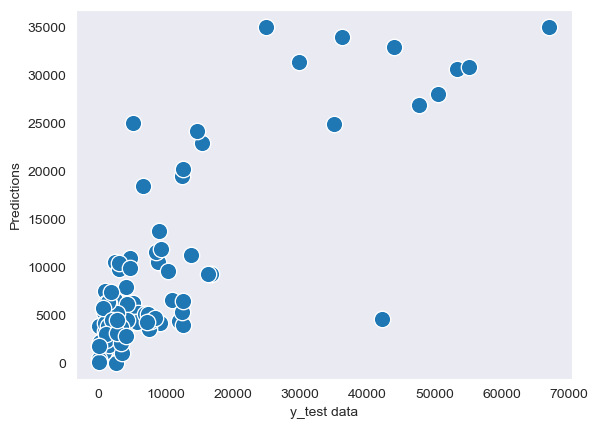

In [1446]:
sns.scatterplot(x=y_test, y = y_pred, s=140)
plt.xlabel('y_test data')
plt.ylabel('Predictions')

## Metrics Log
This contains the metric values output of the model when used on the merged dataset.

In [1447]:
f = open("log.out", "a")

from sklearn.metrics import mean_absolute_error
print('MAE:', mean_absolute_error(y_test,y_pred))
f.write('MAE: {}\n'.format(mean_absolute_error(y_test,y_pred)))

from sklearn.metrics import mean_squared_error
print("MSE",mean_squared_error(y_test,y_pred))
f.write('MSE: {}\n'.format(mean_squared_error(y_test,y_pred)))

import numpy as np
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
f.write('RMSE: {}\n'.format(np.sqrt(mean_squared_error(y_test,y_pred))))

from sklearn.metrics import r2_score
r2 = r2_score(y_test,y_pred)
print("R2 Score:", r2)      # We use this as our main metric
f.write('R2 Score: {}\n'.format(r2))

f.write('---\n')

MAE: 5122.135095236047


23

MSE 67747923.27719158


23

RMSE 8230.912663683876


24

R2 Score: 0.6342261070368445


29

4

In [1448]:
data = data.reset_index()
NewData = data
NewData

,Date,CO conc (ppm),NO2 conc (ppb),O3 conc (ppm),Pb conc (ug/m3 SC),PM2.5 conc (ug/m3 LC),SO2 conc (ppb),Total Cases,Confirmed Cases,Sum New Cases
0,2020-02-02,0.731325,20.180833,0.038462,0.025000,8.592361,1.094737,3,3.0,3.0
1,2020-02-03,0.282000,18.041969,0.038169,0.007180,4.044853,0.338028,6,6.0,3.0
2,2020-02-18,0.648387,29.483333,0.040142,0.015500,11.305473,1.044231,13,13.0,5.0
3,2020-02-19,0.535294,29.044000,0.042117,0.024000,13.664000,0.991489,15,15.0,2.0
4,2020-02-21,0.668122,35.289085,0.042520,0.008195,10.878610,0.753801,17,17.0,2.0
...,...,...,...,...,...,...,...,...,...,...
494,2022-09-30,0.339706,19.176724,0.048478,0.017473,7.819079,1.076923,11253453,10412352.0,11226.0
495,2022-10-06,0.352239,21.045045,0.054648,0.020241,11.354140,0.887179,11278564,10437463.0,25111.0
496,2022-10-07,0.398507,23.880180,0.053995,0.020548,10.971875,0.923077,11284337,10437463.0,11546.0
497,2022-10-13,0.332836,18.396364,0.046519,0.017320,11.032911,0.634211,11305666,10458792.0,21329.0


In [1449]:
# For CO conc (ppm) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['CO conc (ppm)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['CO conc (ppm)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='CO conc (ppm)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & CO conc (ppm)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

LinearRegression()

Model Evaluation

Linear Regression: RMSE=13547.43, R2=0.01
P(CO conc (ppm)): 0.03949006032167536
There is a significant relationship between the predictor and the response



In [1450]:
# For NO2 conc (ppb) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['NO2 conc (ppb)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['NO2 conc (ppb)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='NO2 conc (ppb)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & NO2 conc (ppb)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

LinearRegression()

Model Evaluation

Linear Regression: RMSE=13477.68, R2=0.02
P(NO2 conc (ppb)): 0.002211830227186298
There is a significant relationship between the predictor and the response



In [1451]:
# For O3 conc (ppm) & Sum New Cases
## Perform regression modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
import calendar

# Convert datetime to int
#x = data['Date'].values.astype(int) / 10**9  # Convert to seconds (UNIX epoch start)
#x = x.reshape(-1, 1)


x = NewData['O3 conc (ppm)']
y = NewData['Sum New Cases']

#--------------------------------------------------------------
# Linear regression model
#--------------------------------------------------------------
# Stastical approach
x_lms = sm.add_constant(x)
linear_model_stat = sm.OLS(y, x_lms)
lms_results = linear_model_stat.fit()
p_values = lms_results.pvalues[1:]

# Machine learning approach (no p-values)
linear_model = LinearRegression()
linear_model.fit(x_lms, y)
y_linear_pred = linear_model.predict(x_lms)

# Calculate R2 and RMSE for linear regression model
linear_r2 = r2_score(y, y_linear_pred)
linear_rmse = np.sqrt(mean_squared_error(y, y_linear_pred))

print("Model Evaluation")
print("\nLinear Regression: RMSE=%.2f, R2=%.2f" % (linear_rmse, linear_r2))
for i, p_value in enumerate(p_values.index):
  print(f'P({p_value}): {p_values[i]}')

if any(p_values <= 0.05):
  print("There is a significant relationship between the predictor and the response\n")
else:
  print("There is no significant relationship between the predictor and the response\n")


# Plot the model
import plotly.graph_objects as go

xtt = NewData['O3 conc (ppm)']#.dt.strftime('%Y-%m-%d')
scatter_actual = go.Scatter(x=xtt, y=y, mode='markers', name='Actual', marker=dict(color='blue', opacity=0.3))

line_regression = go.Scatter(x=xtt, y=y_linear_pred, mode='lines', name='LR', line=dict(color='red', dash='dash'))

data = [scatter_actual, line_regression]

layout = go.Layout(xaxis=dict(title='O3 conc (ppm)'),
                   yaxis=dict(title='Sum New Cases'),
                   title='Linear Regression Model for COVID-19 New Cases & O3 conc (ppm)',
                   showlegend=True,
                   height=600)

fig = go.Figure(data=data, layout=layout)
fig.show()

LinearRegression()

Model Evaluation

Linear Regression: RMSE=13518.89, R2=0.01
P(O3 conc (ppm)): 0.011850185140676633
There is a significant relationship between the predictor and the response

